<a href="https://colab.research.google.com/github/chaitanyasatyasai/Multilingual_Doc_Analyzer/blob/main/Multilingual_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install deep-translator==1.7.3
!pip install PyPDF2==1.26.0
!pip install neo4j==4.4.0
!pip install httpx==0.23.0
!pip install groq==0.16.0
!pip install python-dotenv==0.19.2


ERROR: Could not find a version that satisfies the requirement deep-translator==1.7.3 (from versions: 0.0.1, 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.3.1, 0.4.1, 0.4.2, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.0.9, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.1.6, 1.1.7, 1.1.8, 1.1.9, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.2.6, 1.2.7, 1.2.8, 1.2.9, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5, 1.3.6, 1.3.7, 1.3.8, 1.3.9, 1.4.0, 1.4.1, 1.4.2, 1.4.3, 1.4.4, 1.5.0, 1.5.1, 1.5.4, 1.5.5, 1.6.0, 1.6.1, 1.7.0, 1.8.0, 1.8.1, 1.8.3, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0, 1.10.1, 1.11.0, 1.11.1, 1.11.4)
ERROR: No matching distribution found for deep-translator==1.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61082 sha256=524caaece98b844c3c40e782a78a9ae39f960286d87c426845bff412675361e3
  Stored in directory: /root/.cache/pip/wheels/71/61

In [ ]:
!pip install deep-translator==1.11.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import os
#from dotenv import load_dotenv
from google.colab import userdata

# Access secrets from Colab's Secrets Manager
NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')
GROQ_API_KEY = userdata.get('GROQ_API_KEY')


In [ ]:
import os
import spacy
from neo4j import GraphDatabase
from groq import Groq
import PyPDF2

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
!pip install pdfplumber==0.7.6

In [ ]:
from deep_translator import GoogleTranslator

def translate_to_english(text, source_language="auto"):
    """Translate text to English using Deep Translator."""
    try:
        translator = GoogleTranslator(source=source_language, target="en")
        translated_text = translator.translate(text)
        print(f"Translated text: {translated_text}")
        return translated_text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text

In [ ]:
class KnowledgeGraph:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
        self.session = self.driver.session()

    def store_entities(self, entities, relations):
         """Create nodes for entities and relationships in Neo4j."""
         def create_entity(tx, name):
             tx.run("MERGE (e:Entity {name: $name})", name=name.strip())

         def create_relation(tx, start, rel, end):
             tx.run("""
                 MATCH (a:Entity {name: $start}), (b:Entity {name: $end})
                 MERGE (a)-[:RELATION {type: $rel}]->(b)
                 """, start=start.strip(), end=end.strip(), rel=rel.strip())

         # Store nodes
         for entity in entities:
            self.session.write_transaction(create_entity, entity)
            print(f"✅ Stored Entity: {entity}")

    # Store relationships
         for start, relation, end in relations:
            self.session.write_transaction(create_relation, start, relation, end)
            print(f"✅ Stored Relation: ({start})-[:{relation}]->({end})")
    def debug_graph(self):
          """Print all nodes and relationships."""
          print("\n🔍 Nodes in Neo4j:")
          nodes = self.session.run("MATCH (n:Entity) RETURN n LIMIT 10")
          for node in nodes:
              print(node["n"]["name"])

          print("\n🔗 Relationships in Neo4j:")
          rels = self.session.run("""
          MATCH (a:Entity)-[r:RELATION]->(b:Entity)
          RETURN a.name AS start, r.type AS relation, b.name AS end
          """)
          for record in rels:
              print(f"({record['start']})-[:{record['relation']}]->({record['end']})")



    def query_graph(self, query):
        """Query Neo4j graph and return results."""
        result = self.session.run(
            """
            MATCH (a)-[r]->(b)
            WHERE a.name CONTAINS $query OR b.name CONTAINS $query
            RETURN a, r, b
            """, {"query": query}
        )
        return [(record["a"].get("name"), record["r"].get("type"), record["b"].get("name")) for record in result]

    def close(self):
        self.session.close()
        self.driver.close()

In [ ]:
import pdfplumber

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF using pdfplumber for better accuracy."""
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text() or ""
            #print(f"Extracted Page Text: {page_text}")
            text += page_text
    return text


In [ ]:
def extract_entities(text):
    """Extract entities and relationships from the text."""
    doc = nlp(text)
    entities = set([ent.text for ent in doc.ents])

    relations = []
    for token in doc:
        if token.dep_ in ("nsubj", "dobj") and token.head.pos_ == "VERB":
            relations.append((token.head.text, token.dep_, token.text))
    return entities, relations

def query_response(query):
    """Generate a response using Groq API (Llama 3.3)."""
    client = Groq(api_key=GROQ_API_KEY)

    chat_completion = client.chat.completions.create(
        messages=[{"role": "user", "content": query}],
        model="llama-3.3-70b-versatile",
        stream=False,
    )

    return chat_completion.choices[0].message.content

In [ ]:
def main():
    pdf_path = input("Enter the path to the PDF file: ")

    # Extract and process text
    text = extract_text_from_pdf(pdf_path)
    print("Text extracted successfully.")

    # Translate text if not in English
    text = translate_to_english(text)

    # Extract entities and relationships
    entities, relations = extract_entities(text)
    print("Entities and Relations extracted.")
    print("Entities:", entities)
    print("Relations:", relations)

    # Store in Neo4j
    kg = KnowledgeGraph(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)
    kg.store_entities(entities, relations)
    print("Entities and relationships stored in the Knowledge Graph.")

    # User Query and Response
    user_query = input("Enter your query: ")
    graph_results = kg.query_graph(user_query)
    print("Graph-based search results:", graph_results)

    # Use LLM to interpret graph output
    enriched_query = f"Context: {graph_results}. User Query: {user_query}"
    response = query_response(enriched_query)
    print("Response:", response)

    kg.close()

if __name__ == "__main__":
    main()


Enter the path to the PDF file: /content/ml-2.pdf
Text extracted successfully.
Error during translation: Request exception can happen due to an api connection error. Please check your connection and try again
Entities and Relations extracted.
Entities: {'3', 'గూగుల్\u200c', 'వసుి వినియోగ రద్తధ', 'వివేకంత కూడుకని', 'షియల ్\u200cఇంటెలిజెన్స ్\u200c (కృప్తిమ మేధ్', 'ర్థ్సే', 'రీ-ఇన్్\u200cఫోరస', 'టరి', 'వినిమయ శకి', 'ంగ', 'మెషిన్్\u200c లరి ంగ్\u200cకి స్ంబంధంచి', 'ర్ంగు చిప్తాల', 'ంటిది', 'ప్యర్', 'ఉరయోగాలు', 'ప్యర్వ', 'ప్ోప్గామ్\u200cలను', 'మాలోేని', '4', 'విడిగా', 'కొత ిఆవిషక ర్ణలు', 'వాూ ధ లక్షణ రరశీలన', 'మెషిన్్\u200c లరి', 'తరి', 'ప్రజ్)ా', 'ర్చన', 'నడిపే', 'కూడిన', 'ఆరఫిట షియల్\u200c', 'ఆరఫిట షియల్\u200c ఇంటెలిజెన్స ్\u200c', 'టర్నుే', 'ఉరర్ంగం', 'ప్టేజ్\u200c - వాూ', 'ఆరఫిట', '2', 'వేర్లవ', 'నిర్యాణ లు తీసుకొని', 'రకాలు', '1', 'విశ్లషిే', 'అరర్ూ', '్\u200c అనేది న్యూ ర్ల్\u200c', 'అలవాట్లే', 'రర్ూ'}
Relations: [('మెషీన్', 'nsubj', 'లేదా'), ('మెషీన్', 'nsubj', 'లేకండా'), ('మెషీన్',

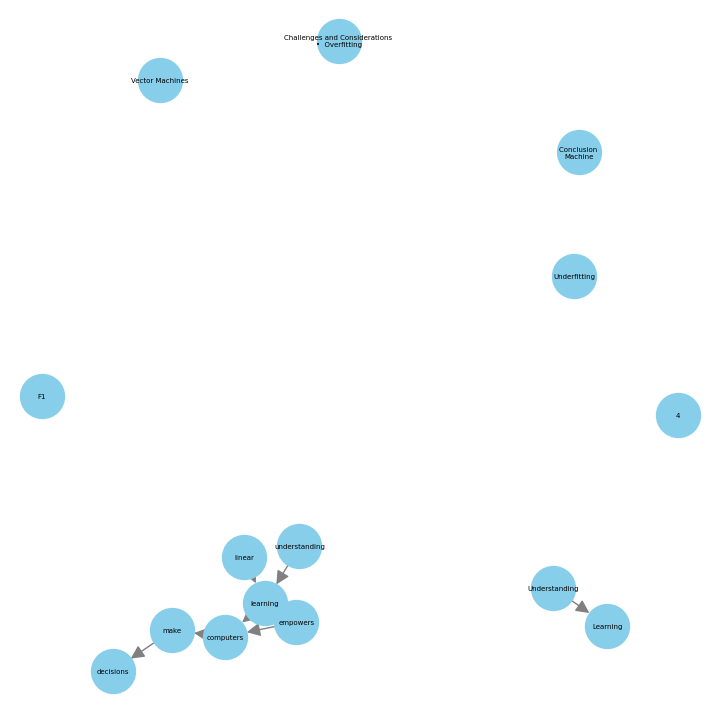

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# # Add nodes and edges
entities = {'4', 'F1', 'Conclusion \nMachine', 'Challenges and Considerations \n•  Overfitting', 'linear', 'Underfitting', 'Vector Machines'}
relations = [('Understanding', 'Learning'), ('empowers', 'computers'), ('make', 'decisions'),('learning', 'computers'),('linear', 'learning'),('computers', 'make'), ('understanding', 'learning'),('computers', 'make')]

G.add_nodes_from(entities)
G.add_edges_from(relations)

# Use a spring layout for better visualization
pos = nx.spring_layout(G, k=0.3)

plt.figure(figsize=(7, 7))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=5, edge_color="gray", arrowsize=20)
plt.show()


In [ ]:
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print(f"Available RAM: {ram_gb:.2f} GB")


Available RAM: 13.61 GB
